In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
########################   读取数据  #########################################
sheet = pd.read_excel('data_input/中国10债Trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet.set_index('Date', inplace=True) 
sheet = sheet.reset_index().rename(columns={'index': 'Date'})

使用手动设置的斜率 = 0.002118, 截距 = 1.518184


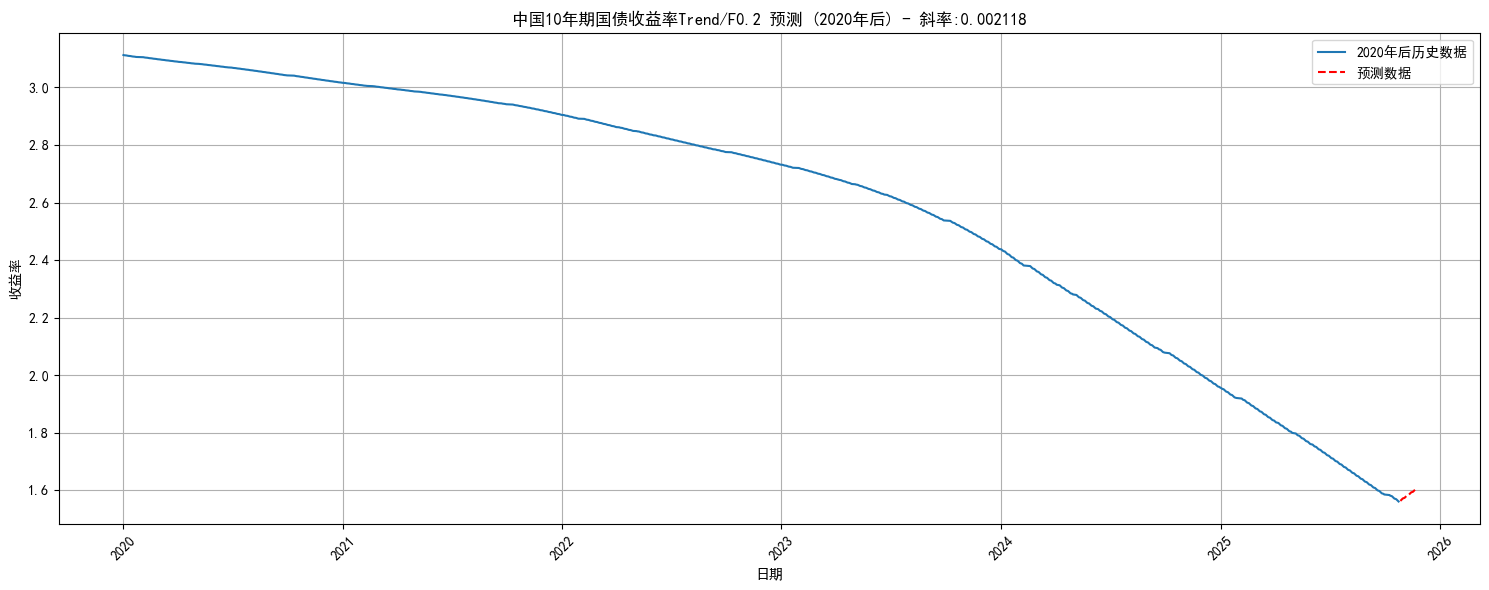

In [5]:
sheet = sheet.dropna()
# 获取最后一个日期
last_date = pd.to_datetime(sheet['Date'].iloc[-1])
# 生成未来21个工作日
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')  # 生成30天以确保获得21个工作日
future_dates = future_dates[future_dates.dayofweek < 5][:21]  # 只保留工作日并取前21天

# 获取最后21个历史值用于线性回归
last_values = sheet['中国10年期国债收益率Trend/F0.2'].tail(21).values
x = np.arange(len(last_values))
y = last_values.astype(float)  # 确保y值为浮点数类型

# 是否使用手动斜率
use_manual_slope = True  # 设置为True时使用手动斜率，False时使用自动计算的斜率
manual_slope =  0.002118  # 手动设置的斜率值

if use_manual_slope:
    # 使用手动斜率
    slope = manual_slope
    intercept = y[-1] - slope * x[-1]  # 使用最后一个历史数据点计算截距
    print(f"使用手动设置的斜率 = {slope:.6f}, 截距 = {intercept:.6f}")
else:
    # 使用自动计算的斜率（原来的方式）
    z = np.polyfit(x, y, 1)
    slope, intercept = z[0], z[1]
    print(f"自动计算的斜率 = {slope:.6f}, 截距 = {intercept:.6f}")

# 预测未来21个值
future_x = np.arange(len(last_values), len(last_values) + len(future_dates))  # 修正future_x长度
future_values = slope * future_x + intercept

# 创建预测数据框
future_df = pd.DataFrame({
    'Date': future_dates,
    '中国10年期国债收益率Trend/F0.2': future_values
})

# 合并历史数据和预测数据
sheet_with_predictions = pd.concat([sheet, future_df], ignore_index=True)

# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2020-01-01']

# 绘制结果
plt.figure(figsize=(15, 6))
plt.plot(sheet_2020['Date'], sheet_2020['中国10年期国债收益率Trend/F0.2'], label='2020年后历史数据')
plt.plot(future_df['Date'], future_df['中国10年期国债收益率Trend/F0.2'], 'r--', label='预测数据')
plt.title(f'中国10年期国债收益率Trend/F0.2 预测 (2020年后) - 斜率:{slope:.6f}')
plt.xlabel('日期')
plt.ylabel('收益率')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
########################   读取数据  #########################################
sheet_non_trend = pd.read_excel('eta/中国10年期国债收益率Non-Trend_合并数据.xlsx', sheet_name='Sheet1')

In [7]:
# 将Date列转换为datetime64[ns]格式
sheet_non_trend['Date'] = pd.to_datetime(sheet_non_trend['Date'])

# 合并两个数据框,使用outer方式对齐日期
merged_df = pd.merge(
    sheet_non_trend[['Date', '预测值_全量']], 
    future_df[['Date', '中国10年期国债收益率Trend/F0.2']], 
    on='Date',
    how='outer'
)

# 删除包含空值的行
merged_df = merged_df.dropna()

# 计算最终的中国10年期国债收益率
merged_df['中国10年期国债收益率'] = merged_df['预测值_全量'] + merged_df['中国10年期国债收益率Trend/F0.2']


merged_df.head()

,Date,预测值_全量,中国10年期国债收益率Trend/F0.2,中国10年期国债收益率
540,2025-10-27,0.28510,1.562662,1.847762
541,2025-10-28,0.28510,1.564780,1.849880
542,2025-10-29,0.28581,1.566898,1.852708
543,2025-10-30,0.28581,1.569016,1.854826
544,2025-10-31,0.28581,1.571134,1.856944


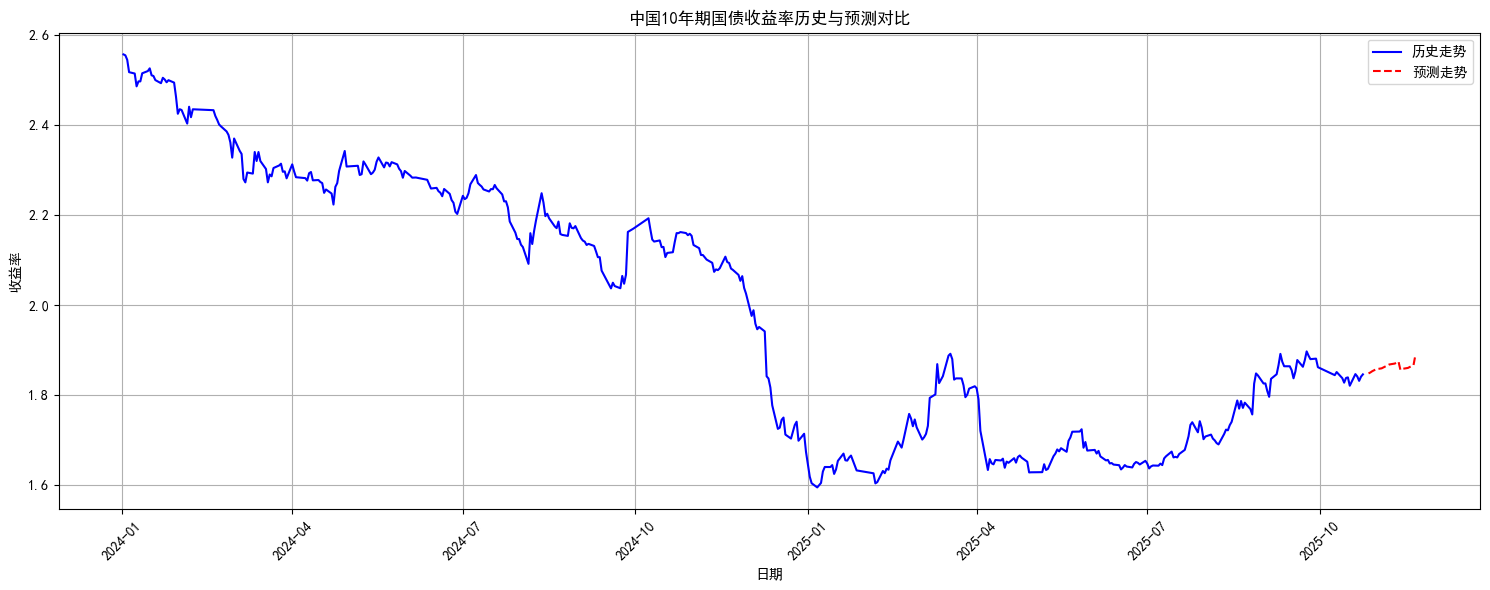

In [8]:
# 绘制最终走势图
plt.figure(figsize=(15, 6))

# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2024-01-01']

# 绘制历史数据
plt.plot(sheet_2020['Date'], sheet_2020['中国10年期国债收益率'], label='历史走势', color='blue')

# 添加垂直分隔线,标记历史数据和预测数据的分界点
last_historical_date = sheet_2020['Date'].iloc[-1]
#plt.axvline(x=last_historical_date, color='gray', linestyle='--', label='历史/预测分界线')

# 绘制预测数据
plt.plot(merged_df['Date'], merged_df['中国10年期国债收益率'], label='预测走势', color='red', linestyle='--')

plt.title('中国10年期国债收益率历史与预测对比')
plt.xlabel('日期')
plt.ylabel('收益率')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

In [9]:
sheet_data_2023 = sheet[sheet['Date'].dt.year >= 2023][['Date', '中国10年期国债收益率Trend/F0.2']]
sheet_data_2023.columns = ['Date', '实际值']
merged_df_trend = pd.merge(sheet_data_2023, future_df, on='Date', how='outer')
merged_df_trend = merged_df_trend.sort_values('Date', ascending=False)
merged_df_trend['Date'] = merged_df_trend['Date'].dt.strftime('%Y/%m/%d')
merged_df_trend.to_excel('eta/中国10年期国债收益率Trend_F0.2_合并数据.xlsx', index=False,float_format='%.8f')
merged_df_trend

,Date,实际值,中国10年期国债收益率Trend/F0.2
698,2025/11/21,NaN,1.602904
697,2025/11/20,NaN,1.600786
696,2025/11/19,NaN,1.598668
695,2025/11/18,NaN,1.596550
694,2025/11/17,NaN,1.594432
...,...,...,...
4,2023/01/09,2.727982,NaN
3,2023/01/06,2.728762,NaN
2,2023/01/05,2.729539,NaN
1,2023/01/04,2.730314,NaN


In [10]:
# 将日期列转换为datetime格式
merged_df_trend['Date'] = pd.to_datetime(merged_df_trend['Date'])

# 按月份重采样并取每月最后一个交易日的数据
monthly_df_trend = merged_df_trend.set_index('Date').resample('ME').last()
monthly_df_trend = monthly_df_trend.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_trend = monthly_df_trend.reset_index()
monthly_df_trend['Date'] = monthly_df_trend['Date'].dt.strftime('%Y/%m/%d')
monthly_df_trend = monthly_df_trend.round(3)
# 保存月度数据到Excel
monthly_df_trend.to_excel('eta/中国10年期国债收益率Trend_F0.2_月度数据.xlsx', index=False, float_format='%.2f')

monthly_df_trend.head()

,Date,实际值,中国10年期国债收益率Trend/F0.2
0,2025/11/30,NaN,1.603
1,2025/10/31,1.561,1.571
2,2025/09/30,1.585,NaN
3,2025/08/31,1.630,NaN
4,2025/07/31,1.673,NaN


---

In [11]:
sheet_data_2023_shizhi = sheet[sheet['Date'].dt.year >= 2023][['Date', '中国10年期国债收益率']]
sheet_data_2023_shizhi.columns = ['Date', '实际值']
future_df_shizhi = merged_df[['Date', '中国10年期国债收益率']]
merged_df_shizhi = pd.merge(sheet_data_2023_shizhi, future_df_shizhi, on='Date', how='outer')
merged_df_shizhi = merged_df_shizhi.sort_values('Date', ascending=False)
merged_df_shizhi['Date'] = merged_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
merged_df_shizhi.to_excel('eta/中国10年期国债收益率_合并数据.xlsx', index=False,float_format='%.5f')
merged_df_shizhi.head()

,Date,实际值,中国10年期国债收益率
698,2025/11/21,NaN,1.888714
697,2025/11/20,NaN,1.866286
696,2025/11/19,NaN,1.864168
695,2025/11/18,NaN,1.862050
694,2025/11/17,NaN,1.859932


In [12]:
# 将日期列转换为datetime格式
merged_df_shizhi['Date'] = pd.to_datetime(merged_df_shizhi['Date'])

# 按月份重采样并取每月最后一个交易日的数据
monthly_df_shizhi = merged_df_shizhi.set_index('Date').resample('ME').last()
monthly_df_shizhi = monthly_df_shizhi.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_shizhi = monthly_df_shizhi.reset_index()
monthly_df_shizhi['Date'] = monthly_df_shizhi['Date'].dt.strftime('%Y/%m/%d')

# 保存月度数据到Excel
monthly_df_shizhi.to_excel('eta/中国10年期国债收益率_月度数据.xlsx', index=False, float_format='%.2f')

monthly_df_shizhi.head()

,Date,实际值,中国10年期国债收益率
0,2025/11/30,NaN,1.888714
1,2025/10/31,1.8456,1.856944
2,2025/09/30,1.8616,NaN
3,2025/08/31,1.8433,NaN
4,2025/07/31,1.7015,NaN


---

In [13]:
future_predictions = merged_df_shizhi[['Date', '中国10年期国债收益率']]
future_predictions = future_predictions.dropna()
future_predictions['Date'] = pd.to_datetime(future_predictions['Date'])
future_predictions = future_predictions.sort_values('Date')
future_predictions.to_csv('data_output/中国10年期国债收益率_未来日度预测.csv', index=False)
future_predictions.head()

,Date,中国10年期国债收益率
679,2025-10-27,1.847762
680,2025-10-28,1.849880
681,2025-10-29,1.852708
682,2025-10-30,1.854826
683,2025-10-31,1.856944


---

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国10年期国债收益率Trend/F0.2"

# 调用函数更新数据
success = update_excel_data(merged_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国10年期国债收益率2.0"

# 调用函数更新数据
success = update_excel_data(merged_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国10年期国债收益率Trend/F0.2"

# 调用函数更新数据
success = update_excel_data(monthly_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [17]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国10年期国债收益率2.0"

# 调用函数更新数据
success = update_excel_data(monthly_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [18]:
'''
from Ecel import generate_and_fill_excel
success = generate_and_fill_excel(
    daily_df =  merged_df_shizhi,
    target_name = '中国10年期国债收益率2.0',        # 写入的"预测标的"显示名
    TARGET_COL = '中国10年期国债收益率', 
    output_path='update.xlsx'
)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Ecel import generate_and_fill_excel\nsuccess = generate_and_fill_excel(\n    daily_df =  merged_df_shizhi,\n    target_name = \'中国10年期国债收益率2.0\',        # 写入的"预测标的"显示名\n    TARGET_COL = \'中国10年期国债收益率\', \n    output_path=\'update.xlsx\'\n)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'